In [119]:
import glob, os, json

In [120]:
os.chdir("/kaggle/input/data-for-ocr/lines_w25")
txt_lst = []
png_lst =[]
for file in glob.glob("*.txt"):
    txt_lst.append(file)
for file in glob.glob("*.png"):
    png_lst.append(file)

In [123]:
# txt_lst

['72659_a.gt.txt',
 '4343_b.gt.txt',
 '51385_a.gt.txt',
 '25082_a.gt.txt',
 '78330_a.gt.txt',
 '83999_a.gt.txt',
 '81468_b.gt.txt',
 '90217_a.gt.txt',
 '80288_b.gt.txt',
 '64679_a.gt.txt',
 '43297_a.gt.txt',
 '94686_a.gt.txt',
 '20403_a.gt.txt',
 '75868_b.gt.txt',
 '30516_b.gt.txt',
 '97710_a.gt.txt',
 '3653_a.gt.txt',
 '43615_b.gt.txt',
 '20840_b.gt.txt',
 '43201_b.gt.txt',
 '80009_a.gt.txt',
 '52557_a.gt.txt',
 '45316_b.gt.txt',
 '15517_b.gt.txt',
 '14490_a.gt.txt',
 '74902_a.gt.txt',
 '98166_b.gt.txt',
 '27624_a.gt.txt',
 '12784_b.gt.txt',
 '37833_b.gt.txt',
 '34220_a.gt.txt',
 '67766_a.gt.txt',
 '15107_b.gt.txt',
 '31076_a.gt.txt',
 '27061_b.gt.txt',
 '78334_b.gt.txt',
 '65752_b.gt.txt',
 '26154_a.gt.txt',
 '70835_b.gt.txt',
 '16990_b.gt.txt',
 '50059_b.gt.txt',
 '9622_b.gt.txt',
 '95654_b.gt.txt',
 '5978_b.gt.txt',
 '69028_b.gt.txt',
 '77948_a.gt.txt',
 '72802_b.gt.txt',
 '41382_b.gt.txt',
 '10372_b.gt.txt',
 '80716_a.gt.txt',
 '59382_a.gt.txt',
 '63599_a.gt.txt',
 '91320_a.gt.txt

In [15]:
print(len(txt_lst), len(png_lst))

200002 200002


In [128]:
path ="/kaggle/input/data-for-ocr/lines_w25/"

In [126]:
png_lst[3][:-4]

'96623_a'

In [129]:
f = open(path + png_lst[3][:-4]+".gt.txt", "r", encoding="utf8").read()[:-1]
f

'роприятие в район 17.00,'

In [130]:
d={}
for i in range(len(png_lst)):
    f = open(path + png_lst[i][:-4]+".gt.txt", "r", encoding="utf8").read()[:-1]
    d[png_lst[i]] = f

In [131]:
len(d)

200002

In [132]:
with open('/kaggle/working/data.json', 'w') as fp:
    json.dump(d, fp)

In [133]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt
from albumentations.core.transforms_interface import ImageOnlyTransform
from PIL import Image, ImageOps, ImageEnhance

In [134]:
with open('/kaggle/working/data.json') as f:
    train_data = json.load(f)

train_data = [(k, v) for k, v in train_data.items()]
print('train len', len(train_data))

split_coef = 0.75
train_len = int(len(train_data)*split_coef)

train_data_splitted = train_data[:train_len]
val_data_splitted = train_data[train_len:]

print('train len after split', len(train_data_splitted))
print('val len after split', len(val_data_splitted))


with open('/kaggle/working/train_labels_splitted.json', 'w') as f:
    json.dump(dict(train_data_splitted), f)
    
with open('/kaggle/working/val_labels_splitted.json', 'w') as f:
    json.dump(dict(val_data_splitted), f)

train len 200002
train len after split 150001
val len after split 50001


In [136]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

config_json = {
    "alphabet": " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№",
    "save_dir": "/kaggle/working/",
    "num_epochs": 10,
    "image": {
        "width": 256,
        "height": 32
    },
    "train": {
        "root_path": "/kaggle/input/data-for-ocr/lines_w25/",
        "json_path": "/kaggle/working/train_labels_splitted.json",
        "batch_size": 256
    },
    "val": {
        "root_path": "/kaggle/input/data-for-ocr/lines_w25/",
        "json_path": "/kaggle/working/val_labels_splitted.json",
        "batch_size": 128
    }
}

cuda


In [137]:
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, json_path, root_path, tokenizer, batch_size, drop_last
):
    dataset = OCRDataset(json_path, root_path, tokenizer, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=8,
        shuffle = False
    )
    return data_loader


class OCRDataset(Dataset):
    def __init__(self, json_path, root_path, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.data_len = len(data)

        self.img_paths = []
        self.texts = []
        for img_name, text in data.items():
#             print(os.path.join(root_path, img_name)," ",text)
            self.img_paths.append(os.path.join(root_path, img_name))
            self.texts.append(text)
        self.enc_texts = tokenizer.encode(self.texts)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
#         print(img_path)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
#         print(image,text,enc_text)
        return image, text, enc_text


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [138]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [139]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
#         print(true)
#         print(pred)
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

In [140]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image
def int_parameter(level, maxval):
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def empty(pil_img, _):
    return pil_img


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def invert(pil_img, _):
    return ImageOps.invert(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                             Image.AFFINE, (1, level, 0, 0, 1, 0),
                             resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                             Image.AFFINE, (1, 0, 0, level, 1, 0),
                             resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                             Image.AFFINE, (1, 0, level, 0, 1, 0),
                             resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                             Image.AFFINE, (1, 0, 0, 0, 1, level),
                             resample=Image.BILINEAR)


def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)



def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)

augmentations = [
    autocontrast, equalize
]

# augmentations = [
#     autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
#     translate_x, translate_y
# ]

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)


def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    ws = np.float32(
        np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        image_aug = image_aug.astype(np.float32) / 255
        mix += ws[i] * image_aug
    #         mix += ws[i] * normalize(image_aug)
    # visualize(m)
    image = image.astype(np.float32) / 255
    mixed = (1 - m) * image + m * mix
    # mixed = image_aug
    #     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def __call__(self, image, **params):
    # def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image


def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        RandomAugMix(severity=10, width=7, alpha=5., p=1.),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        RandomAugMix(severity=10, width=7, alpha=5., p=1.),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

In [141]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet18(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

In [142]:
from tqdm.autonotebook import tqdm

In [143]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    for images, texts, _, _ in tqdm(data_loader):
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    return acc_avg.avg


def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, texts, enc_pad_texts, text_lens in tqdm(data_loader):
        model.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(texts)
        output = model(images)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg


def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds


def get_loaders(tokenizer, config):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    train_loader = get_data_loader(
        json_path=config['train']['json_path'],
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True
    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_loader = get_data_loader(
        transforms=val_transforms,
        json_path=config['val']['json_path'],
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False
    )
    return train_loader, val_loader


def train(config):
    tokenizer = Tokenizer(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    train_loader, val_loader = get_loaders(tokenizer, config)

    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.to(DEVICE)

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.5, patience=15)
    best_acc = -np.inf
    acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    for epoch in range(config['num_epochs']):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
            model_save_path = os.path.join(
                config['save_dir'], f'model-{epoch}-{acc_avg:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            print('Model weights saved')

In [144]:
train(config_json)

  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.0000


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 0, Loss: 2.93533, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.0016
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 1, Loss: 0.06267, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.0017
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 2, Loss: 0.01609, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.0587
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 3, Loss: 0.00507, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.9564
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 4, Loss: 0.00382, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.6843


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 5, Loss: 0.01354, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.9907
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 6, Loss: 0.00213, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.9934
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 7, Loss: 0.00075, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.9955
Model weights saved


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 8, Loss: 0.00988, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.3644


  0%|          | 0/586 [00:00<?, ?it/s]


Epoch 9, Loss: 0.00105, LR: 0.0010000


  0%|          | 0/391 [00:00<?, ?it/s]

Validation, acc: 0.9960
Model weights saved


In [145]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)
#         print(images, pred)

        if one_image:
            return pred[0]
        else:
            return pred

In [146]:
predictor = OcrPredictor(
    model_path='/kaggle/working/model-9-0.9960.ckpt',
    config=config_json
)

In [83]:
os.chdir("/kaggle/input/data-for-ocr/lines_w25")
png_lst =[]
for file in glob.glob("*.png"):
    png_lst.append(file)

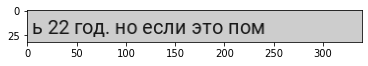

Prediction:  ь 22 год. но если это пом


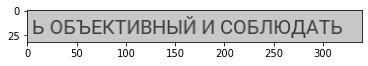

Prediction:  Ь ОБЪЕКТИВНЫЙ И СОБЛЮДАТЬ


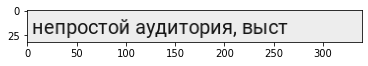

Prediction:  непростой аудитория, выст


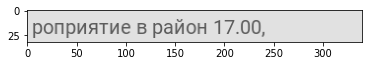

Prediction:  роприятие в район 17.00,


In [147]:
pred_json = {}

count = 0
print_images = True
for img_name in png_lst:
    img = cv2.imread(f'/kaggle/input/data-for-ocr/lines_w25/{img_name}')
#     print(img)
    pred = predictor(img)
    pred_json[img_name] = pred

    if print_images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        print('Prediction: ', predictor(img))
        count += 1

    if count > 3:
        print_images = False
        break